# Hands-on: EDA

This hands-on will cover some techniques for exploratory data analysis using the Citibike Trip Histories dataset. The first few sections include code to prepare the data.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

Kindly choose a 2021 month file to download (not the ones with JC as the prefix). You can download data for January or Febuary (20-50MB in file size for slow internet connections) and extract it to your data folder.

In [2]:
os.environ['DSDATA'] = r'/Users/jamiemapa/Desktop/Acads/TERM 2/DATAPRE/DSDATA'
data = os.getenv('DSDATA')
data

data = pd.read_csv(os.getenv('DSDATA') + '/202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,304,2021-02-01 00:04:23.0780,2021-02-01 00:09:27.7920,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2
1,370,2021-02-01 00:07:08.8080,2021-02-01 00:13:19.4670,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1
2,635,2021-02-01 00:07:55.9390,2021-02-01 00:18:31.0390,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2
3,758,2021-02-01 00:08:42.0960,2021-02-01 00:21:20.7820,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0
4,522,2021-02-01 00:09:32.6820,2021-02-01 00:18:15.4100,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1


## Feature Extraction

In [3]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [4]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [5]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [7]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

In [8]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,634631,634631,634631
unique,1274,1283,2
top,1 Ave & E 68 St,1 Ave & E 68 St,Customer
freq,4251,4226,468459


----
----

# Exploratory Data Analysis


These are the descriptive stats for the categorical variables. 

### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [9]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

55        3793.983333
128       4257.516667
280       1364.983333
287       3014.366667
290       3205.933333
             ...     
631214    7005.816667
632255    1363.300000
633024    5281.700000
633398    6875.366667
633877    1165.300000
Name: duration_min, Length: 624, dtype: float64

## Examine relationships/correlations

### bivariate -  trip duration & time of day

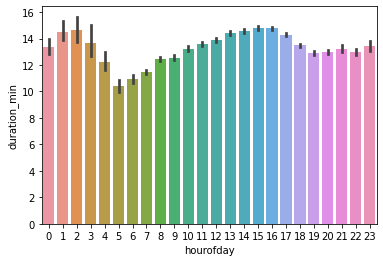

In [12]:
dur_time_plot = sns.barplot(x="hourofday",  
                                   y="duration_min", 
                                   data=data[filtered_entries])

Observations:
- The peak hours where duration is longest is 00:00 - 03:00, goes down until 04:00, and gradually rises until 16:00.


### multi - start station, end station, & unique users

/Users/jamiemapa/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


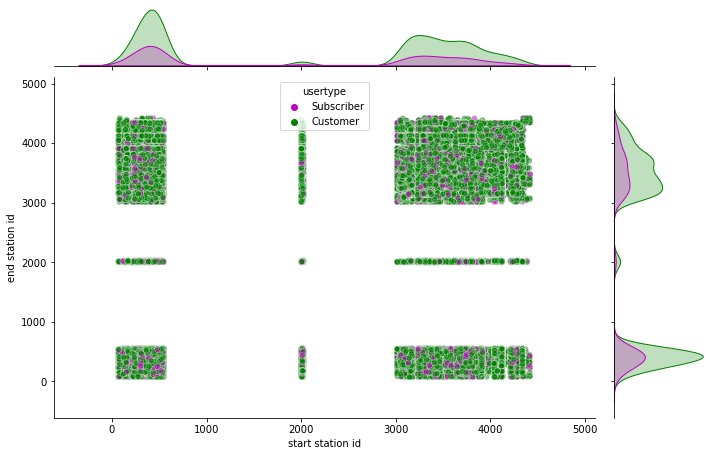

In [15]:
## not sure about this
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")

od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]

start_end_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x= "start station id",
                                   y= "end station id",
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)

start_end_user_plot.fig.set_size_inches(10.5, 6.5)

In [ ]:
## wont run for me
## the correct one i think

od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")

od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]

start_end_user_plot = sns.scatterplot(data=data[filtered_entries], 
                                   x=od_trips["od"],
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)

start_end_user_plot.fig.set_size_inches(10.5, 6.5)